# Hiragana
use CNN to learn and recognize hiragana


### Imports

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import pandas as pd
import random, math, os

from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical  # replaces to_categorical
from tensorflow.keras.callbacks import EarlyStopping


Import and organize data

In [3]:
## Load the dataset
from organize_data import download_hiragana_dataset

download_hiragana_dataset()

In [4]:
## import data into a list
## construct datatable
from organize_data import create_handwriting_table

handwriting_table = create_handwriting_table()
handwriting_table.head()

,Handwriting,Filename,Romanji
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA0.jpg,a
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA1.jpg,a
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA10.jpg,a
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA11.jpg,a
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA12.jpg,a


## Image preprocess


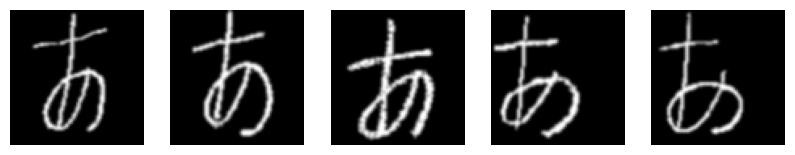

In [5]:
# show the first 5 images
fig, ax = plt.subplots(1, 5, figsize=(10, 10))
for i in range(5):
    ax[i].imshow(handwriting_table.Handwriting[i], cmap='gray')
    ax[i].axis('off')

In [6]:
## process images with threshold = 40
from image_process import im_clean, im_bin, im_reshape, IMG_SIZE
img_rows, img_cols = IMG_SIZE
handwriting_table.Handwriting = handwriting_table.Handwriting.map(lambda img: im_reshape(im_clean(img), img_rows, img_cols))

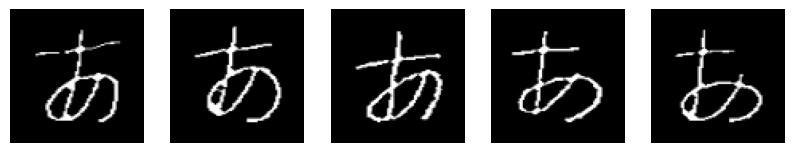

In [7]:
# show the first 5 images
fig, ax = plt.subplots(1, 5, figsize=(10, 10))
for i in range(5):
    ax[i].imshow(handwriting_table.Handwriting[i], cmap='gray')
    ax[i].axis('off')

In [8]:
handwriting_table.Handwriting[0].shape

(84, 84)

## Import another dataset
Import a new dataset created by Wishyut.

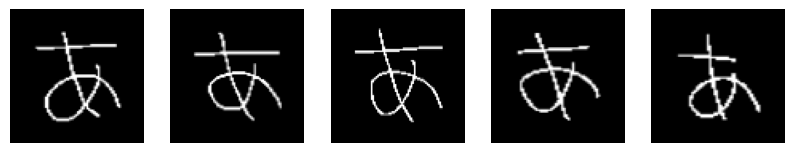

In [9]:
from organize_data import get_handwriting_wishyut
handwriting_table_wishyut = get_handwriting_wishyut()

fig, ax = plt.subplots(1, 5, figsize=(10, 10))
for i in range(5):
    ax[i].imshow(handwriting_table_wishyut.Handwriting[i], cmap='gray')
    ax[i].axis('off')

Organizing Romanji labels
* Organize the different labels with the same pronunciation

In [10]:
# create a function that maps {'hu', 'si', 'ti', 'tu'} to {'fu', 'shi', 'chi', 'tsu'}
from label_process import map_to_hiragana
# apply the function to the Romanji column
handwriting_table.Romanji = handwriting_table.Romanji.map(map_to_hiragana)
handwriting_table_wishyut.Romanji = handwriting_table_wishyut.Romanji.map(map_to_hiragana)

In [11]:
## combine two tables
# handwriting_table = handwriting_table.append(handwriting_table_wishyut, ignore_index=True) # old!
handwriting_table = pd.concat([handwriting_table, handwriting_table_wishyut])
handwriting_table

,Handwriting,Filename,Romanji
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA0.jpg,a
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA1.jpg,a
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA10.jpg,a
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA11.jpg,a
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA12.jpg,a
...,...,...,...
400,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",train_yu_5.png,yu
401,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",train_yu_6.png,yu
402,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",train_yu_7.png,yu
403,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",train_yu_8.png,yu


## Add numerical label to each Romanji (for categorization)

In [12]:
## add labels to the datatable w.r.t. the romanji
from label_process import romanji_to_dict

romanji_dict = romanji_to_dict(handwriting_table["Romanji"])
romanji_categories = len(romanji_dict)
handwriting_table["Label"] = handwriting_table["Romanji"].map(lambda x: romanji_dict[x])

print(romanji_dict)
print(romanji_categories)
handwriting_table.head()

{'shi': 0, 'na': 1, 're': 2, 'to': 3, 'ma': 4, 'nu': 5, 'me': 6, 'o': 7, 'ki': 8, 'n': 9, 'ko': 10, 'te': 11, 'wa': 12, 'wo': 13, 'ra': 14, 'su': 15, 'da': 16, 'e': 17, 'hi': 18, 'mu': 19, 'a': 20, 'chi': 21, 'no': 22, 'pi': 23, 'se': 24, 'he': 25, 'ba': 26, 'mo': 27, 'ne': 28, 'ro': 29, 'ya': 30, 'yo': 31, 'ta': 32, 'yu': 33, 'u': 34, 'ku': 35, 'ho': 36, 'ka': 37, 'sa': 38, 'fu': 39, 'so': 40, 'ji': 41, 'ke': 42, 'mi': 43, 'ha': 44, 'ri': 45, 'i': 46, 'ni': 47, 'tsu': 48, 'ru': 49}
50


,Handwriting,Filename,Romanji,Label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA0.jpg,a,20
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA1.jpg,a,20
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA10.jpg,a,20
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA11.jpg,a,20
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA12.jpg,a,20


In [13]:
## construct X and y data from data-table
X = handwriting_table["Handwriting"].to_numpy()
y = handwriting_table["Label"].to_numpy()

# X = np.array([X[i].reshape(img_rows, img_cols) for i in range(X.shape[0])])
# X = X.reshape(X.shape[0], img_rows, img_cols, 1)
X = np.concatenate(X).reshape(-1, img_rows, img_cols, 1)
X.shape

(1405, 84, 84, 1)

In [14]:
## split the data into training and testing data + one-hot encoding
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y) # , shuffle=True
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train) # , shuffle=True

Y_train_train = to_categorical(y_train_train, romanji_categories)
Y_val = to_categorical(y_val, romanji_categories)
Y_test = to_categorical(y_test, romanji_categories)

X_train.shape

(1194, 84, 84, 1)

### Standardization
standardize the strength of each pixel from 0-255 to 0-1

In [15]:
## standardize X_train and X_test
from organize_data import std_X

X_train_train = std_X(X_train_train)
X_val = std_X(X_val)
X_test = std_X(X_test)

# CNN Model
Construct a CNN model with two convolution blocks, one flattening, and one dense layers.
* Each convolution block contains two convolution layers and a maxpooling layer.

In [16]:
from ml_model import build_hiragana_cnn

input_shape = (img_rows, img_cols, 1)
model = build_hiragana_cnn(input_shape, romanji_categories)

print('model.summary:')
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

model.summary:


c:\Users\physics\miniconda3\envs\ml\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 84, 84, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 84, 84, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 42, 42, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 42, 42, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 42, 42, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28224)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     7,225,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │        12,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,303,442 (27.86 MB)

 Trainable params: 7,303,442 (27.86 MB)

 Non-trainable params: 0 (0.00 B)

# Augmentation
Use the augmentation to generate more data from the training data.
* Use rotate and shear transform to simulate all kinds of handwritings.

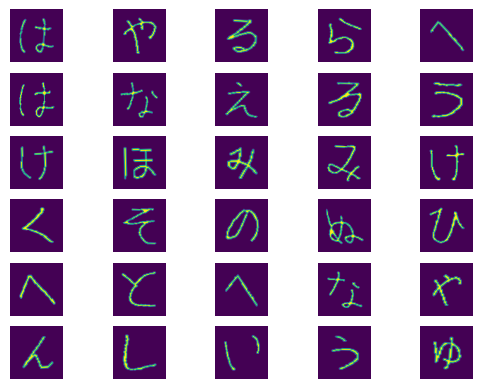

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Range for picking a value from.
datagen = ImageDataGenerator(
    rotation_range=5,
    # width_shift_range=0.05,
    # height_shift_range=0.05,
    shear_range=0.1,
    # zoom_range=0.1,
    fill_mode='nearest',
    validation_split=0.2)


i = 0
for batch in datagen.flow(X_train_train, batch_size=1):
    plt.subplot(6,5,1 + i)
    plt.axis("off")
    
    augImage = batch[0]
    augImage = augImage.astype('float32')
    augImage /= 255
    plt.imshow(augImage)
    
    i += 1
    if i > 29:
        break

In [18]:
## train the model wuth data (including augmentaion datagen)
batch_size = 256  #128
nb_epoch = 16

# fits the model on batches with real-time data augmentation:
train_history = model.fit(datagen.flow(X_train_train, Y_train_train, batch_size=32),
         validation_data=(X_val, Y_val),
         batch_size=batch_size, epochs=nb_epoch, verbose=1,
         callbacks=EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode="auto"))


Epoch 1/16


c:\Users\physics\miniconda3\envs\ml\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.2513 - loss: 3.1412 - val_accuracy: 0.8556 - val_loss: 0.4733
Epoch 2/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.9274 - loss: 0.3084 - val_accuracy: 0.8833 - val_loss: 0.3634
Epoch 3/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.9679 - loss: 0.1221 - val_accuracy: 0.9167 - val_loss: 0.4357
Epoch 4/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.9720 - loss: 0.0981 - val_accuracy: 0.9167 - val_loss: 0.3416
Epoch 5/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.9900 - loss: 0.0506 - val_accuracy: 0.9333 - val_loss: 0.2923
Epoch 6/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.9878 - loss: 0.0490 - val_accuracy: 0.9278 - val_loss: 0.2652
Epoch 7/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.9998 - loss: 0.0040 - val_accuracy: 0.9222 - val_loss: 0.4239
Epoch 8/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.9995 - loss: 0.0040 - val_accuracy: 0.9333 - val_

Plot the training process.

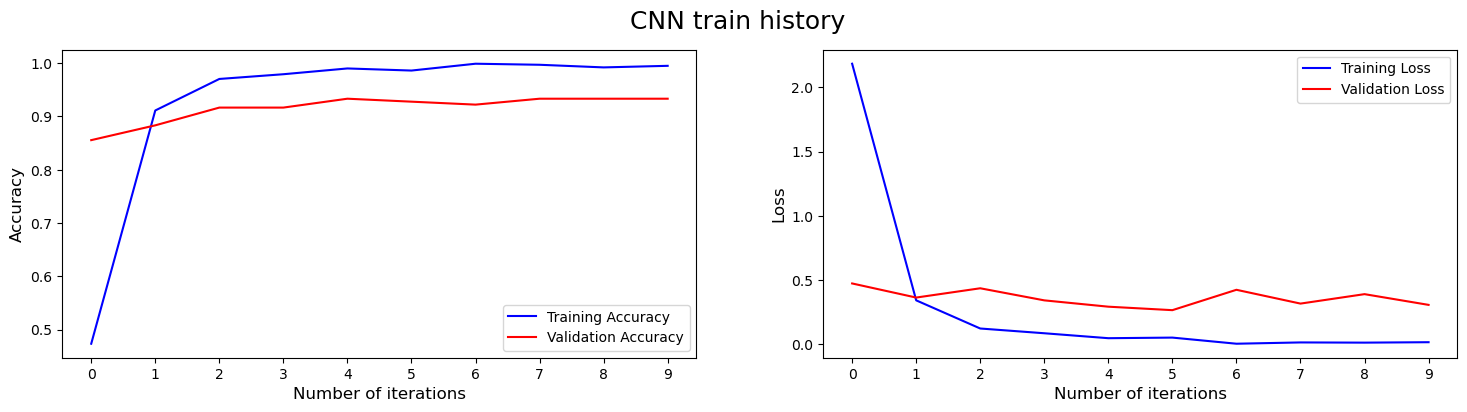

In [19]:
## plot train history
from demonstration import plot_train_history

plot_train_history(train_history)

# Model Evaluation
Evaluate the model with testing data.

In [20]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9573 - loss: 0.1033
Test score: 0.13101287186145782
Test accuracy: 0.9526066184043884


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
total testing data: 211
Number of errors = 10/211
Accuracy: 0.95


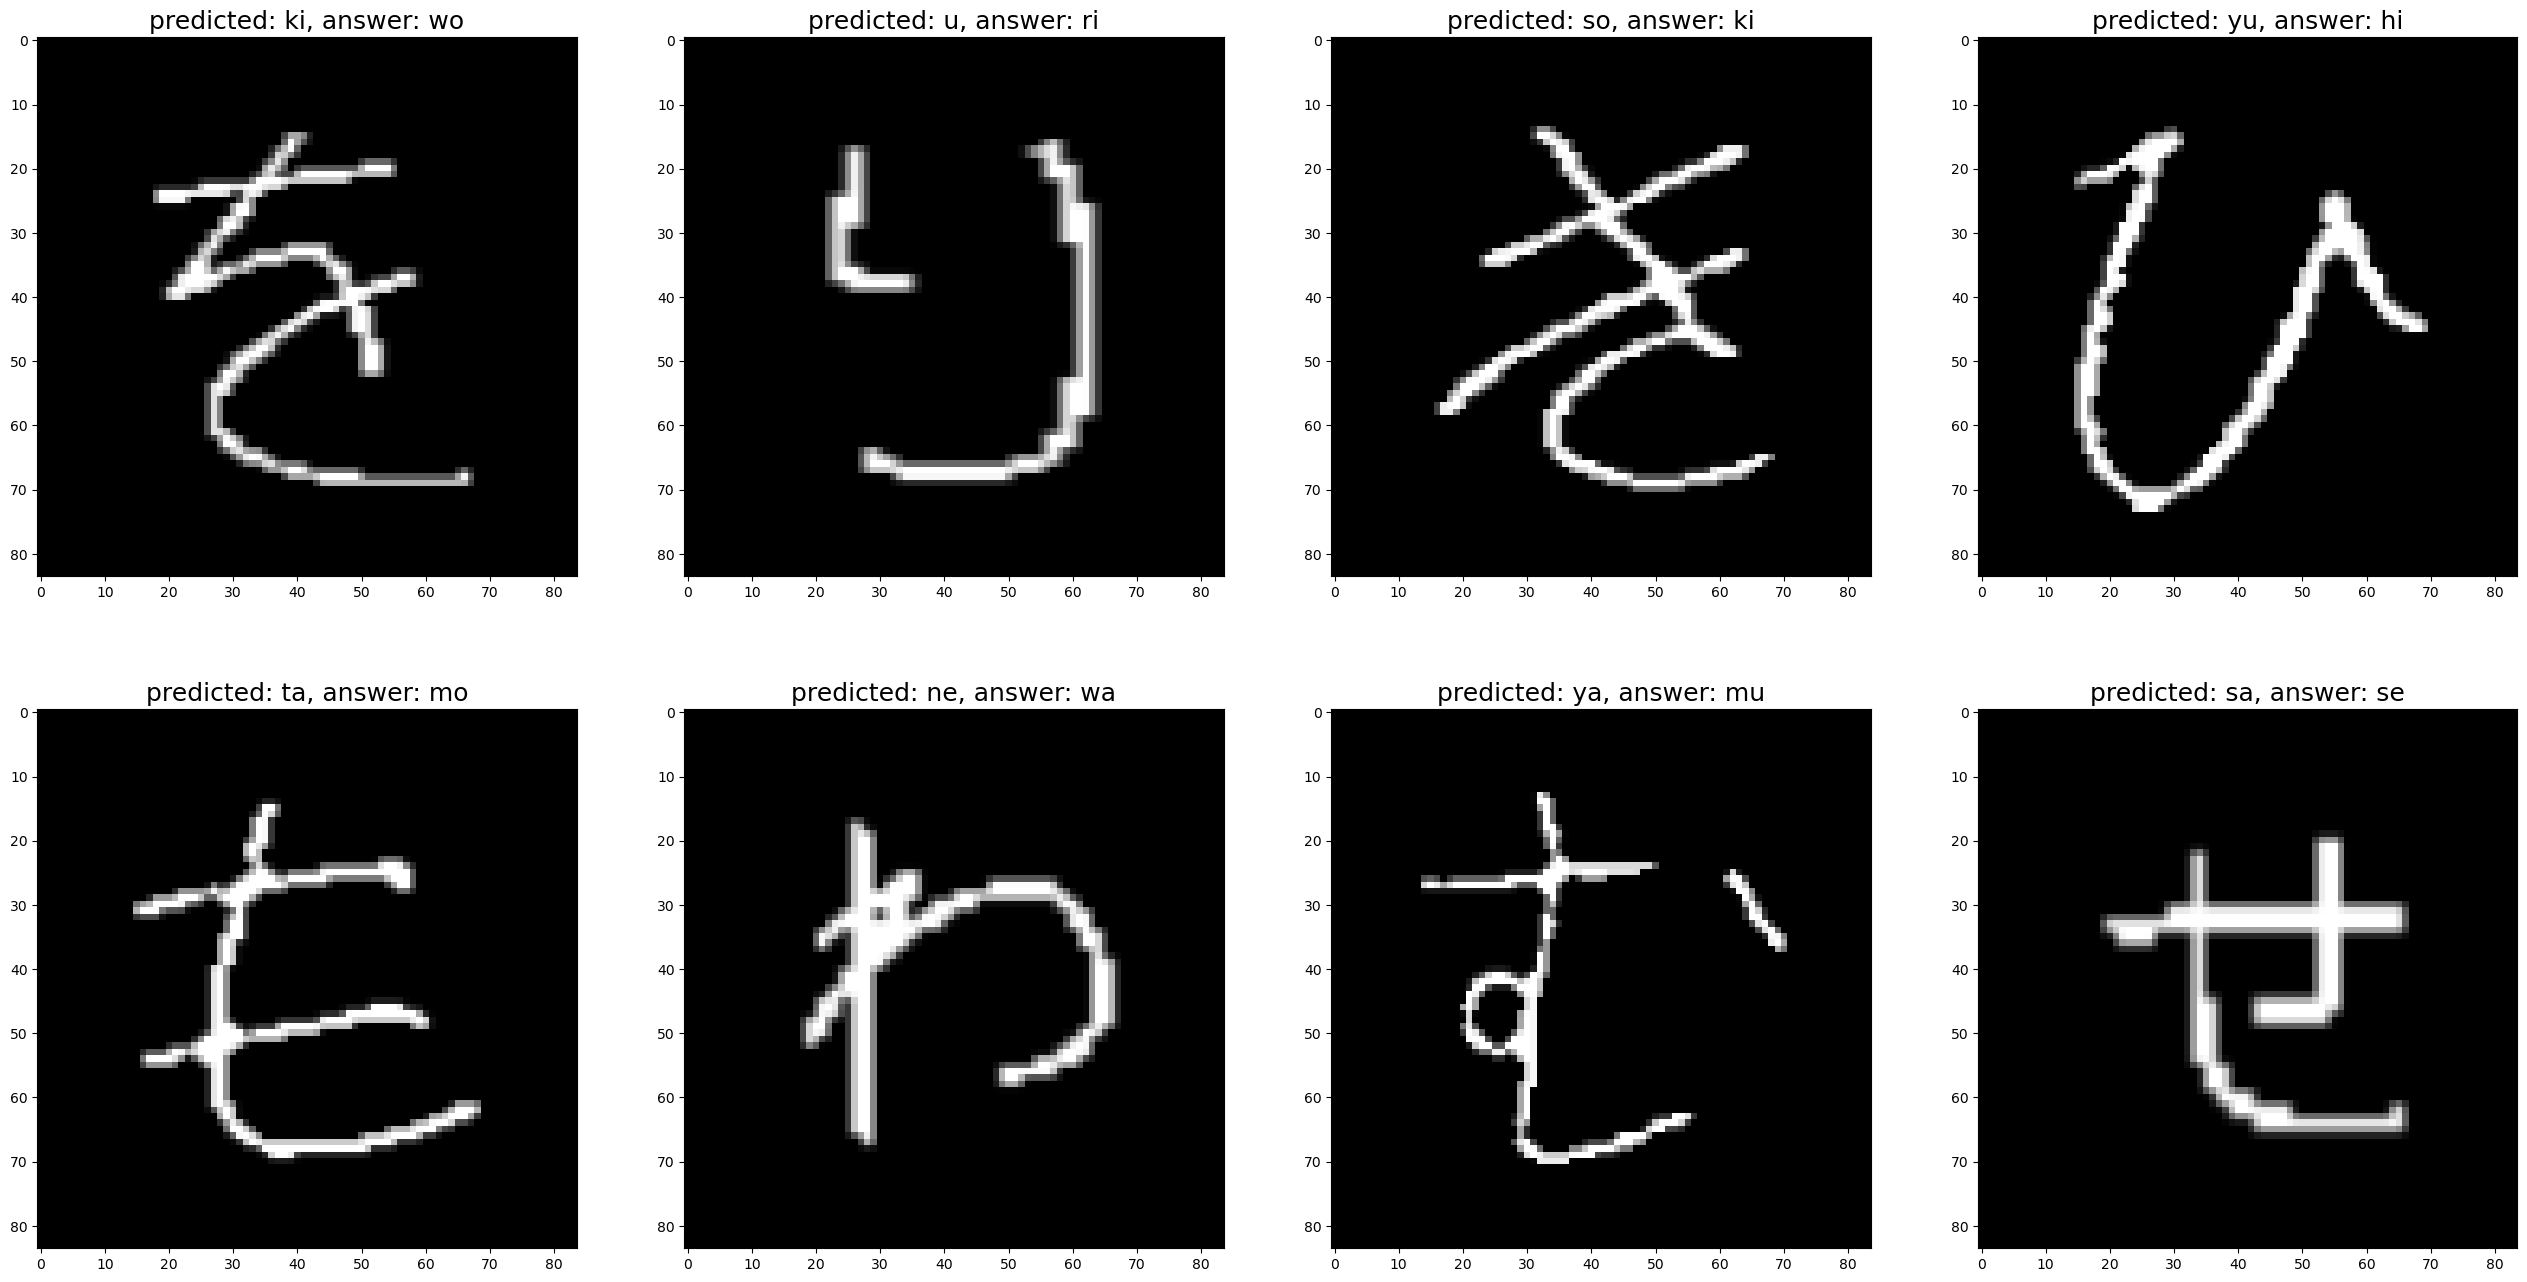

In [21]:
## show the (error) prediction results
from demonstration import get_predictions, show_errs

predictions = get_predictions(X_test, model)
ground_truth = y_test

show_errs(X_test, predictions, ground_truth, romanji_dict)

## Confusion matrix


In [22]:
confusion_matrix = np.zeros((romanji_categories, romanji_categories), dtype=np.uint8)

for predict, answer in zip(predictions, ground_truth):
    confusion_matrix[answer][predict] += 1
confusion_matrix


array([[4, 0, 0, ..., 0, 0, 0],
       [0, 4, 0, ..., 0, 0, 0],
       [0, 0, 4, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 5, 0, 0],
       [0, 0, 0, ..., 0, 4, 0],
       [0, 0, 0, ..., 0, 0, 4]], dtype=uint8)

Confusion matrix, without normalization


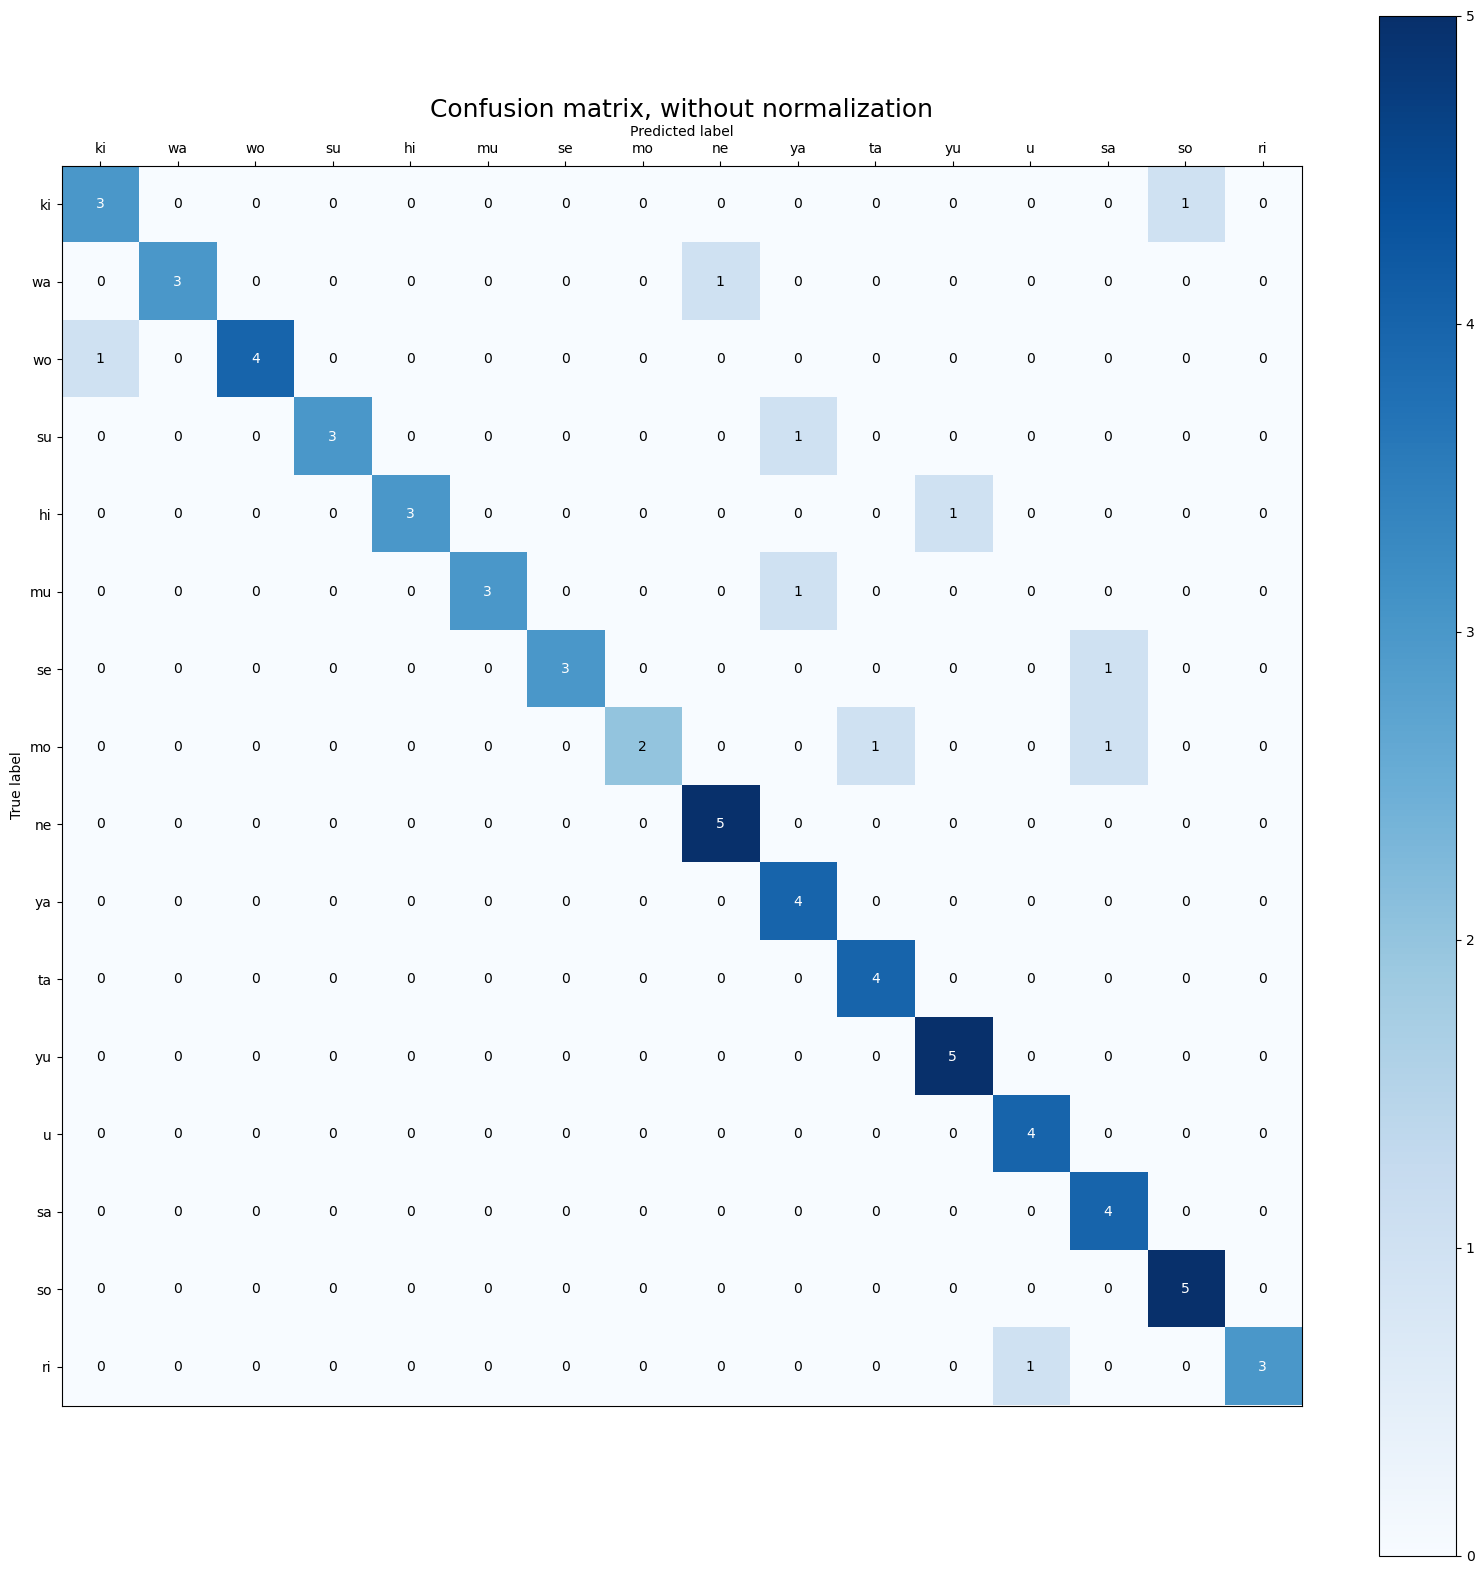

In [23]:
## plot confusion matrix (not normalized)
from demonstration import plot_confusion_matrix

plot_confusion_matrix(confusion_matrix, romanji_dict,
                      title='Confusion matrix, without normalization')


In [24]:
# ## plot normalized confusion matrix
# plot_confusion_matrix(confusion_matrix, romanji_categories,
#                       normalize=True,
#                       title='Confusion matrix, with normalization')


## Cross Valiadation

In [25]:
from sklearn.model_selection import StratifiedKFold

# Assuming X and Y are your original data arrays
skf = StratifiedKFold(n_splits=5, shuffle=True) # , random_state=42

# metrics = []

# for train_index, test_index in skf.split(X, y):
#     X_train_fold, X_test_fold = X[train_index], X[test_index]
#     y_train_fold, y_test_fold = y[train_index], y[test_index]
#     # create a validation set from the training set (for early stopping)
#     X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_test_split(X_train_fold, y_train_fold, test_size=0.15, stratify=y_train_fold) # , shuffle=True

#     Y_train_fold = to_categorical(y_train_fold, romanji_categories)
#     Y_val_fold = to_categorical(y_val_fold, romanji_categories)
#     Y_test_fold = to_categorical(y_test_fold, romanji_categories)

#     X_train_fold = std_X(X_train_fold)
#     X_val_fold = std_X(X_val_fold)
#     X_test_fold = std_X(X_test_fold)

#     input_shape = (img_rows, img_cols, 1)

#     model = build_hiragana_cnn(input_shape, romanji_categories)
#     model.compile(loss='categorical_crossentropy',
#                   optimizer=RMSprop(),
#                   metrics=['accuracy'])
    
#     train_history = model.fit(datagen.flow(X_train_fold, Y_train_fold, batch_size=32),
#                                 validation_data=(X_val_fold, Y_val_fold),
#                                 batch_size=batch_size, epochs=nb_epoch, verbose=0,
#                                 callbacks=EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode="auto"))
    
#     score = model.evaluate(X_test_fold, Y_test_fold, verbose=1)
#     print('Test score:', score[0])
#     print('Test accuracy:', score[1])
#     metrics.append(score[1])

# metrics = np.array(metrics)
# print('Mean accuracy:', metrics.mean())
# print('Standard deviation:', metrics.std())

In [26]:
skf = StratifiedKFold(n_splits=5, shuffle=True) # , random_state=42

metrics = []
costs = []
models = []

for train_index, val_index in skf.split(X_train, y_train): # skf.split(X, y)
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    Y_train_fold = to_categorical(y_train_fold, romanji_categories)
    Y_val_fold = to_categorical(y_val_fold, romanji_categories)

    X_train_fold = std_X(X_train_fold)
    X_val_fold = std_X(X_val_fold)

    model = build_hiragana_cnn(input_shape, romanji_categories)
    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])
    
    train_history = model.fit(datagen.flow(X_train_fold, Y_train_fold, batch_size=32),
                                validation_data=(X_val_fold, Y_val_fold),
                                batch_size=batch_size, epochs=nb_epoch, verbose=0,
                                callbacks=EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode="auto"))
    
    score = model.evaluate(X_val_fold, Y_val_fold, verbose=1)
    print('Validation score:', score[0])
    print('Validation accuracy:', score[1])
    costs.append(score[0])
    metrics.append(score[1])
    models.append(model)

metrics = np.array(metrics)
print('Mean accuracy:', metrics.mean())
print('Standard deviation:', metrics.std())

c:\Users\physics\miniconda3\envs\ml\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\physics\miniconda3\envs\ml\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 10: early stopping
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9535 - loss: 0.2799 
Validation score: 0.377063512802124
Validation accuracy: 0.9414225816726685
Epoch 12: early stopping
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9762 - loss: 0.0791
Validation score: 0.1284170150756836
Validation accuracy: 0.9748954176902771
Epoch 9: early stopping
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9423 - loss: 0.3392
Validation score: 0.2768111228942871
Validation accuracy: 0.9456067085266113
Epoch 6: early stopping
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9383 - loss: 0.4092
Validation score: 0.42366746068000793
Validation accuracy: 0.9330543875694275
Epoch 10: early stopping
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9143 - loss: 0.4692
Validation score: 0.368135929107666
Validation accuracy: 0.9327731132507324
Mean accuracy: 0.9455504417419434
Standard deviation: 0.01547631416950185


In [27]:
# for model in models:
#     score = model.evaluate(X_test, Y_test, verbose=1)
#     print('Test score:', score[0])
#     print('Test accuracy:', score[1])

## decide the best model
model_vd = models[np.argmin(costs)]
## evaluate the best model
score = model_vd.evaluate(X_test, Y_test, verbose=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9799 - loss: 0.1229


## Test my handwritings
Write hiraganas with paint-2D.

Test my hiragana handwritings with the trained model.

In [54]:
import re

my_handwritings = []
answers_myhw = []
for file in os.listdir("test_my_handwriting"):
    # print(file)
    key = re.search(r'_(\w+?)_', file).group(1)
    # print(key, end=", ")
    answers_myhw.append(key)
    img = cv.imread(f"test_my_handwriting/{file}", cv.IMREAD_GRAYSCALE)
    img = 255 - img
    # print(img.shape)
    img = im_reshape(im_bin(img), img_rows, img_cols)
    my_handwritings.append(img)

my_handwritings = np.array(my_handwritings)
print(my_handwritings.shape)
# print(answers_myhw)

(92, 84, 84)


(92, 84, 84, 1)
3/3 [==============================] - 0s 38ms/step
Number of errors_myhw = 24/92
Accuracy: 0.74


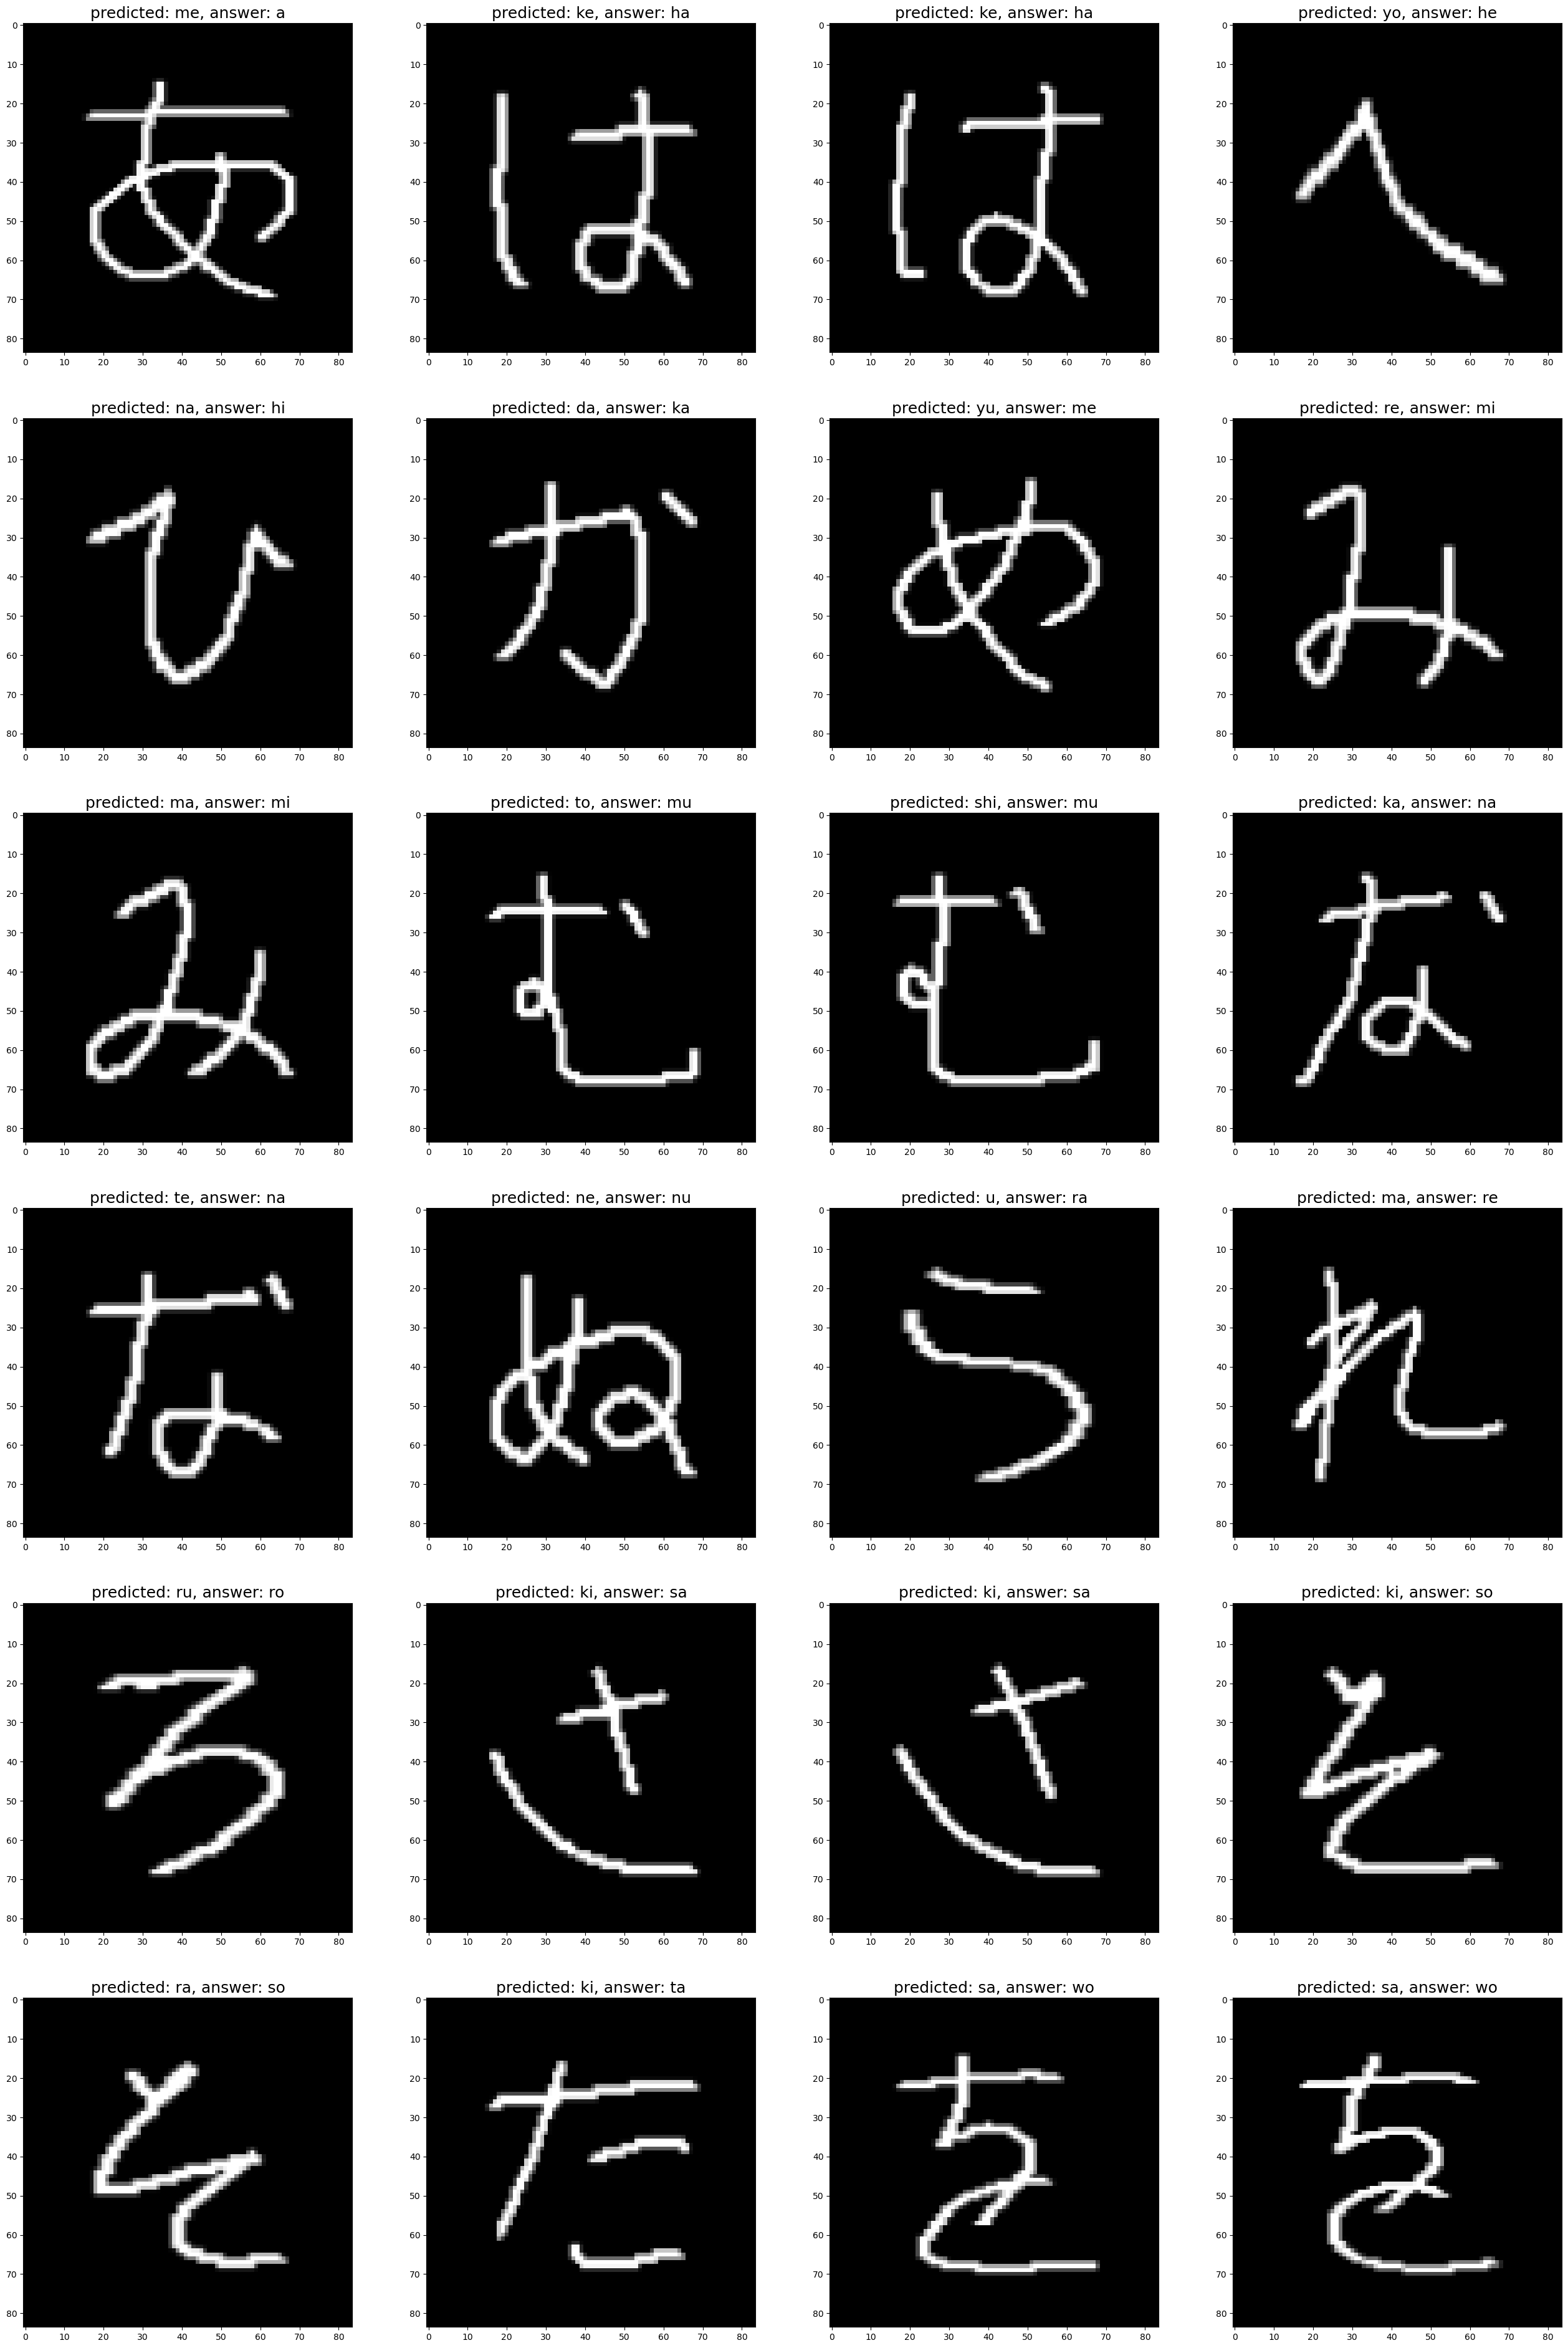

In [55]:
num_myhw = len(my_handwritings)
my_handwritings = my_handwritings.reshape(num_myhw, 84, 84, 1)
my_handwritings = std_X(my_handwritings)
print(my_handwritings.shape)
prob_myhw = model.predict(my_handwritings)
predictions_myhw = np.argmax(prob_myhw,axis=1)
# print(predictions_myhw)
prediction_romanji_myhw = [inv_romanji_dict[prediction] for prediction in predictions_myhw]
# print(prediction_romanji_myhw)
# print(answers_myhw)

errors_myhw = []
for i in range(num_myhw):
    if prediction_romanji_myhw[i] != answers_myhw[i]:
        errors_myhw.append(i)
# print(errors_myhw)
num_err_myhw = len(errors_myhw)
print("Number of errors_myhw = {}/{}".format(num_err_myhw,num_myhw))
print("Accuracy: {:.2f}".format(1-num_err_myhw/num_myhw))

num_eachrow = 4
rows_err = math.ceil(num_err_myhw / num_eachrow)
fig, axes = plt.subplots(rows_err, num_eachrow, figsize=(8*num_eachrow,8*rows_err))
for r in range(rows_err):
    for c in range(num_eachrow):
        n_err = r * num_eachrow + c
        if n_err >= num_err_myhw: break
        pos_err = errors_myhw[n_err]
        # plt.title(f"predicted: {prediction_romanji_myhw[pos_err]}, answer: {answers_myhw[pos_err]}")
        axes[r,c].set_title(f"predicted: {prediction_romanji_myhw[pos_err]}, answer: {answers_myhw[pos_err]}", fontsize=18)
        axes[r,c].imshow(my_handwritings[pos_err], cmap=plt.get_cmap('gray'))

Save the model

In [ ]:
# from keras.models import load_model
# # creates a HDF5 file
# model.save('model_hiragana_recognition_cnn.h5') 
